In [3]:
import json, sys
from IPython.display import Image, display
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages')

In [4]:
objectId = 99999999999
file = 'json/%d.json'%objectId
alert = json.loads(open(file).read())

In [5]:
from bazinBlackBody import BBBEngine
BE = BBBEngine.BBB('LSST', verbose=False)
(dicte, dictb) =  BE.make_fit(alert)

Rsq fit is 0.1794


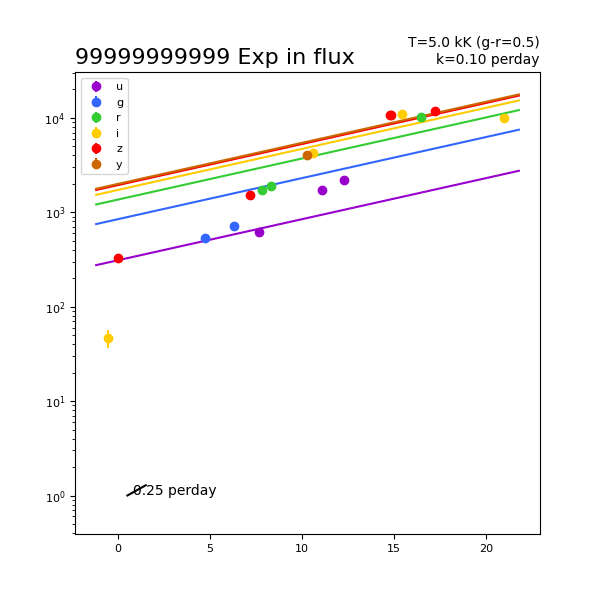

In [6]:
if dicte:
    print('Rsq fit is %.4f' % dicte['Rsq'])
    filename = 'image/%d_e.png'%objectId
    BE.plot(alert, dicte, filename)
    display(Image(filename=filename))

Rsq fit is 0.0004


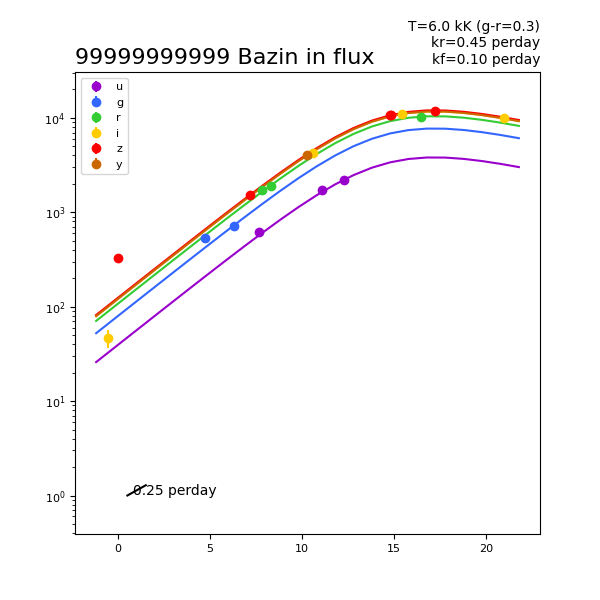

In [7]:
if dictb:
    print('Rsq fit is %.4f' % dictb['Rsq'])
    filename = 'image/%d_b.png'%objectId
    BE.plot(alert, dictb, filename)
    display(Image(filename=filename))